In [ ]:
# Description: Reset the notebook environment (commented out for portfolio view).
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [ ]:
# Description: Import necessary libraries for data analysis, simulation, and optimization.
import numpy as np
import math
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve, minimize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hyperopt import fmin, hp, space_eval, tpe, STATUS_OK, Trials
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
import shap

In [ ]:
# Description: Configure plotting styles and parameters for matplotlib and seaborn.
sns.set_style("ticks", {'xtick.direction': 'in', 'ytick.direction': 'in'})
sns.set_context("notebook", font_scale=2.2, rc={"lines.linewidth": 3.7})

from pylab import *
rc('axes', linewidth=2.5)
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 3

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [ ]:
# Description: Define functions for calculating thermophysical properties of seawater (density, viscosity, diffusivity).
# References:
# Thermophysical properties of seawater: a review of existing correlations and data
# Temperature dependence modeling of reverse osmosis
# Thermodynamic properties of sea salt solutions

def calculate_density(c_feed, T):
    t = T - 273 # t [celcius]
    S = c_feed/1000 # S [kg/kg]

    # Coefficients from the equation
    a1 = 9.999e2
    a2 = 2.034e-2
    a3 = -6.162e-3
    a4 = 2.261e-5
    a5 = -4.657e-8

    b1 = 8.020e2
    b2 = -2.001
    b3 = 1.677e-2
    b4 = -3.060e-5
    b5 = -1.613e-5

    # Calculating the density using the provided equation
    density = (a1 + a2*t + a3*t**2 + a4*t**3 + a5*t**4) + (b1*S + b2*S*t + b3*S*t**2 + b4*S*t**3 + b5*S**2*t**2)

    return density # [kg/m3]

def calculate_dynamic_viscosity(c_feed, T):
    t = T - 273 # t [celcius]
    S = c_feed/1000 # S [kg/kg]

    # Coefficients for A and B as functions of temperature t
    A = 1.541 + 1.998e-2 * t - 9.52e-5 * t**2
    B = 7.974 - 7.561e-2 * t + 4.724e-4 * t**2

    # Equation for pure water viscosity (mu_w)
    mu_w = 4.2844e-5 + (0.157*(t + 64.993)**2 - 91.296)**(-1)

    # Equation for seawater viscosity (mu_sw)
    mu_sw = mu_w * (1 + A * S + B * S**2)

    return mu_sw # [kg/m/s] = [Pa*s]

def calculate_diffusivity_NaCl(T, P):

    # Coefficients for sodium chloride
    A0 = 0.148571  # diffusivity coefficient in 10^-5 cm^2/sec/K
    B0 = -546.453  # temperature dependence constant in K
    C0 = -2.414e-5  # pressure correction factor in bar^-1
    T0 = 139.085  # reference temperature in K

    # Calculate diffusivity using the provided formula
    D = A0 * T * np.exp(B0 * (1 + C0 * P) / (T - T0))
    D_2 = D*1e-9

    return D_2 # [m2/s]

In [ ]:
# Description: Perform polynomial curve fitting to model osmotic coefficients based on temperature and salinity.
from scipy.optimize import curve_fit

temperature = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])  # in °C
salinity = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40])  # in ‰ [g/kg]
osmotic_coefficients = np.array([
    [1.0000, 0.9149, 0.0913, 0.8950, 0.8919, 0.8907, 0.8909, 0.8925, 0.8952],
    [1.0000, 0.9151, 0.9020, 0.8963, 0.8937, 0.8929, 0.8936, 0.8954, 0.8986],
    [1.0000, 0.9151, 0.9024, 0.8972, 0.8950, 0.8946, 0.8956, 0.8978, 0.9011],
    [1.0000, 0.9149, 0.9026, 0.8977, 0.8959, 0.8958, 0.8971, 0.8996, 0.9032],
    [1.0000, 0.9146, 0.9026, 0.8980, 0.8965, 0.8967, 0.8982, 0.9009, 0.9047],
    [1.0000, 0.9143, 0.9025, 0.8981, 0.8967, 0.8972, 0.8989, 0.9017, 0.9057],
    [1.0000, 0.9138, 0.9021, 0.8979, 0.8968, 0.8974, 0.8993, 0.9023, 0.9064],
    [1.0000, 0.9132, 0.9016, 0.8976, 0.8966, 0.8973, 0.8994, 0.9025, 0.9068],
    [1.0000, 0.9126, 0.9010, 0.8971, 0.8962, 0.8970, 0.8992, 0.9025, 0.9068]
])

# Flatten the data
X_temp, X_salin = np.meshgrid(temperature, salinity, indexing='ij')
X = np.vstack([X_temp.ravel(), X_salin.ravel()]).T
y = osmotic_coefficients.ravel()

# Define a 2D polynomial fitting function for regression
def poly_2d(x, a0, a1, a2, a3, a4, a5):
    temp, salinity = x
    return a0 + a1*temp + a2*salinity + a3*temp**2 + a4*salinity**2 + a5*temp*salinity

# Perform curve fitting to find the coefficients
popt, _ = curve_fit(poly_2d, (X_temp.ravel(), X_salin.ravel()), y)

In [ ]:
# Description: Define global parameters for the SWRO system configuration (LG SW400 SR G2).
num_elements_global = 7

c_feed = 5.5 # [kg/m3] Feed concentration
c0 = c_feed  # [kg/m3] Feed concentration
p_feed = 17.2e5
p0 = p_feed      # Feed pressure (Pa)

Q_feed = (178.3)/3600/24    # Feed flow rate (m^3/s)
Q_feed_CV = (178.3)/3600/24    # Feed flow rate (m^3/s)
Q0 = Q_feed # Feed flow rate (m^3/s)
T = 299 # [K]
R = 8.314
Mw = 62.8 # [g/mol]
epsilon_sp = 0.8  # Spacer porosity
H = 660e-6    # Spacer thickness (m)
W = 0.6   # Leaf width (m)
L = 1  # Leaf length (m)
N_leaf = 32
N_hous = 1
alpha = 0.0526  # Foulant sticking efficiency
phi_feed = 1e-9 # Feed foulant concentration
phi0 = phi_feed # Feed foulant concentration
rc = 7.23e19  # Specific cake resistance (m^-2)
pump_eff = 0.8
ERD_eff = 0.95

# Derived parameters
A_m = 2*N_leaf*L*W
dx = 0.01 # [m]
x_span = (0, L)
x = np.arange(0, L+dx, dx)

A_25 = 2.7778e-12*1.0  # Water permeability (m/Pa/s) 1 LMH/bar

beta = 2.83e4 # [m2/kg]
Ca_amount = 0

In [ ]:
# Description: Define Pitzer model parameters and functions for calculating activity coefficients and solubility products.
pitzer_params = {
    ('Ca2+', 'SO4'): {
        'beta0': 0.10,
        'beta1': 1.40,
        'C_phi': 0.00027
    }
}

# Function to calculate standard K_sp at P_0 and T
def calculate_standard_Ksp(T):
    """
    Calculates the standard solubility product K_sp at standard pressure P_0 and temperature T.
    """
    # Standard Gibbs free energies of formation at 298.15 K (in J/mol)
    deltaGf_CaSO4_2H2O = -1797.9e3    # J/mol for CaSO4·2H2O(s)
    deltaGf_Ca2plus = -553.6e3        # J/mol for Ca2+(aq)
    deltaGf_SO42minus = -744.5e3      # J/mol for SO4^2-(aq)
    deltaGf_H2O = -237.14e3           # J/mol for H2O(l)

    # Calculate ΔG° for the correct dissolution reaction:
    deltaG0 = (deltaGf_Ca2plus + deltaGf_SO42minus + 2 * deltaGf_H2O) - deltaGf_CaSO4_2H2O

    # Calculate K_sp using ΔG° = -RT ln K_sp
    K_sp_0 = math.exp(-deltaG0 / (R * T))

    return K_sp_0

def calculate_activity_coefficients_Pitzer(c_Ca, c_SO4, T):
    # Charges
    z_Ca = +2
    z_SO4 = -2

    # Absolute value of charge for z^2
    z = abs(z_Ca)
    z_squared = z ** 2

    # Molality (mol/kg)
    molality_Ca = c_Ca  # mol/kg
    molality_SO4 = c_SO4  # mol/kg
    molality = c_Ca # = c_SO4

    # Ionic strength
    I = 0.5 * (molality_Ca * z_Ca**2 + molality_SO4 * z_SO4**2)
    sqrt_I = math.sqrt(I)

    # Debye-Hückel term
    A_phi = 0.392  # Depends on temperature and dielectric constant
    B = 1.2  # kg^0.5·mol^-0.5

    ln_gamma_DH = - (A_phi * z_squared * sqrt_I) / (1 + B * sqrt_I)

    # Pitzer parameters
    beta0 = pitzer_params[('Ca2+', 'SO4')]['beta0']
    beta1 = pitzer_params[('Ca2+', 'SO4')]['beta1']
    C_phi = pitzer_params[('Ca2+', 'SO4')]['C_phi']

    # Additional terms
    molality_beta = 2 * beta0 * molality
    molality_beta1 = 2 * beta1 * molality / (1 + math.exp(2 * I))
    molality_C_phi = 2 * C_phi * molality**2

    # Calculate mean activity coefficient (gamma±)
    ln_gamma_mean = ln_gamma_DH + molality_beta + molality_beta1 + molality_C_phi

    gamma_mean = math.exp(ln_gamma_mean)

    # Individual ion activity coefficients
    gamma_Ca = gamma_mean
    gamma_SO4 = gamma_mean

    return gamma_Ca, gamma_SO4

# Function to adjust K_sp for pressure
def adjust_Ksp_pressure(Ksp_0, delta_V, P, P_0, T):
    delta_P = P - P_0  # Pressure difference in Pa
    RT = R * T
    ln_Ksp_adjusted = math.log(Ksp_0) - (delta_V * delta_P) / RT
    K_sp_adjusted = math.exp(ln_Ksp_adjusted)
    return K_sp_adjusted

In [ ]:
# Description: Define the error function for solving the permeate velocity.
def func_vp(var, p, fos, B, MTC, c, mu, Rm, rc, delta_c, ms, beta, dA, Rc):
    vp = var
    rs = vp/(vp+B)
    CP = 1-rs+rs*np.exp(vp/MTC)
    Ab = beta*ms/dA
    error = vp - ((p - 100000 - fos*rs*CP*c)/(mu*Rm + Rc + mu*rc*delta_c)*(1-Ab))

    return error

In [ ]:
# Description: Define the system of Ordinary Differential Equations (ODEs) representing the RO element dynamics.
def system_odes(x, y):
    u, c, p, delta_c, phi, ms, mc = y # ms [kg]

    H_star = H - 2*delta_c # [m]
    dH = 2*epsilon_sp*H_star # [m]
    Re = rho*u*dH/mu # [-]
    Sc = mu/D/rho # [-]

    fsp = 16.41*Re**-0.403 * 1.18
    MTC = 0.065*Re**0.875*Sc**0.25*D/dH # [m/s]
    rx_order = 1
    dA = dx*W
    alpha_crystal_growth = 4.15e14 # [m/kg]
    beta = 2.83e4 # [m2/kg]
    k_s_0 = 1e-6 # [m/s]
    Ab0 = beta*ms0/dA

    P_std = 1e5       # 1 bar in Pa
    delta_V = -7e-6  # Negative if volume decreases upon dissolution
    K_sp_0 = calculate_standard_Ksp(T)
    Ksp_gypsum = adjust_Ksp_pressure(K_sp_0, delta_V, p, P_std, T) # [mol2/kg2] gypsum solubility product
    c_Ca = c*Ca_amount/40.08/rho*1000 # [mol/kg]
    c_Ca_unit = c*Ca_amount #c*0.0114 # [kg/m3]
    c_SO4 = c*0.0771/96/rho*1000 # [mol/kg]
    c_SO4_unit = c*0.0771 # [kg/m3]
    c_Na = c*0.3086/22.99/rho*1000 # [mol/kg]
    c_Cl = c*0.5543 /35.45/rho*1000 # [mol/kg]
    gamma_Ca, gamma_SO4 = calculate_activity_coefficients_Pitzer(c_Ca, c_SO4, T)

    a_Ca = gamma_Ca * c_Ca # [mol/kg]
    a_SO4 = gamma_SO4 * c_SO4 # [mol/kg]
    ionic_product = a_Ca * a_SO4 # # [mol^2/kg^2]
    supersaturation = ionic_product/Ksp_gypsum
    MW_gypsum = 0.17217 # [kg/mol]
    C_s = np.sqrt(Ksp_gypsum/(gamma_Ca*gamma_SO4))*MW_gypsum*rho # [kg/m3] gypsum solubility
    k_s = k_s_0*(supersaturation-1)**rx_order
    k_b = 8.52e-9 # [m3/s] # k_b
    Rc = alpha_crystal_growth*mc/dA #[1/m]

    vp0 = np.abs((p-100000-fos*c)/(mu*Rm + Rc + mu*rc*delta_c)*(1-Ab0))
    vp = fsolve(func_vp, vp0, args=(p, fos, B, MTC, c, mu, Rm, rc, delta_c, ms, beta, dA, Rc))[0]

    rs = vp/(vp+B)
    CP = 1-rs+rs*np.exp(vp/MTC)

    ddelta_c_dx = (alpha*vp*phi)/u # [-]
    dH_dx = -2*ddelta_c_dx
    du_dx = (-2*vp - epsilon_sp*u*dH_dx)/(epsilon_sp*H_star)
    dc_dx = -2*vp*(CP*c*B/(B+vp))/(epsilon_sp*u*H_star) - c*(H_star*du_dx + u*dH_dx)/u/H_star
    dp_dx = -0.5*rho*fsp*u**2/dH # [Pa/m]

    dphi_dx = -(u0*phi0*(2/epsilon_sp)*(vp/H_star)/u**2) - (2/epsilon_sp)*(alpha*vp*phi/H_star)

    if c_Ca_unit-C_s > 0:
        dms_dx = (k_s*(dA-beta*ms)*(c_Ca_unit*CP-C_s)**rx_order)/u # [kg/s] -> [kg/m]
        dmc_dx = (k_b*(c_Ca_unit-C_s)**rx_order)/u # [kg/s] -> [kg/m]

    else:
        dms_dx = 0
        dmc_dx = 0 # [kg/s] -> [kg/m]

    return np.array([du_dx, dc_dx, dp_dx, ddelta_c_dx, dphi_dx, dms_dx, dmc_dx])

In [ ]:
# Description: Function to solve the RO system for a single element configuration.
def one_element_solve(y0, Q0):

    sol = solve_ivp(system_odes, x_span, y0, dense_output=True, method='LSODA', rtol=1e-9, atol=1e-12)
    y = sol.sol(x)
    u_profile, c_profile, p_profile, delta_c_profile, phi_profile, ms_profile, mc_profile = y

    H_star_profile = H - 2 * delta_c_profile # [m]
    dH_profile = 2 * epsilon_sp * H_star_profile # [m]
    Re_profile = rho*u_profile*dH_profile/mu # [-]
    Sc = mu/D/rho # [-]

    MTC_profile = 0.065*Re_profile**0.875*Sc**0.25*D/dH_profile # [m/s]
    rx_order = 1
    dA = dx*W
    alpha_crystal_growth = 4.15e14 # [m/kg]
    beta = 2.83e4 # [m2/kg]
    Ab_profile = beta*ms_profile/dA
    Rc_profile = alpha_crystal_growth*mc_profile/dA #[1/m]

    vp0 = np.abs((p_profile-100000-fos*c_profile)/(mu*Rm + Rc_profile + mu*rc*delta_c_profile)*(1-Ab_profile))
    vp_profile = fsolve(func_vp, vp0, args=(p_profile, fos, B, MTC_profile, c_profile, mu, Rm, rc, delta_c_profile, ms_profile, beta, dA, Rc_profile))
    rs = vp_profile/(vp_profile+B)
    CP_profile = 1-rs+rs*np.exp(vp_profile/MTC_profile)
    cm_profile = CP_profile*c_profile

    p_o_profile = fos*rs*CP_profile*c_profile # [Pa]
    p_o_profile_2 = fos*rs*c_profile # [Pa]
    p_c_profile = vp_profile*rc*mu*delta_c_profile # [Pa]
    p_x_profile = p_feed - p_profile

    p_m_profile = p_profile - p_o_profile - p_c_profile
    p0_profile = p_m_profile + p_o_profile + p_c_profile + p_x_profile

    Qp = A_m*N_hous*np.trapz(vp_profile, x, dx=dx)
    Qb = Q0 - Qp

    Y = Qp/Q_feed # Recovery
    rej = np.mean(rs)
    CF = (1-Y*(1-rej))/(1-Y)
    cp_profile = cm_profile*(B/(B+vp_profile)) # permeate

    cb2 = c0*(1-Y*(1-rej))/(1-Y)
    cb3 = (Q0*c0 - Qp*cp_profile[-1])/Qb
    cb = c_profile[-1] # brine

    return Qb, Qp, Y, rej, cb, cp_profile[-1], p_profile[-1], phi_profile[-1], delta_c_profile[-1], p_o_profile[-1], p_c_profile[-1], p_x_profile[-1], p_m_profile[-1], ms_profile[-1], Ab_profile[-1], np.mean(vp_profile), CP_profile[-1], p_o_profile_2[-1], Re_profile[-1]

In [ ]:
# Description: Run the simulation loop for a multi-element SWRO system and store results.
num_elements_list = [num_elements_global]
df_SW = pd.DataFrame()

for i in range(len(num_elements_list)):
    num_elements = num_elements_list[i]

    rho = calculate_density(c_feed, T) # Density (kg/m^3)
    mu = calculate_dynamic_viscosity(c_feed, T)
    D = calculate_diffusivity_NaCl(T, p_feed/1e5)
    fos_coeff = poly_2d((T-273, c_feed), *popt)
    fos = fos_coeff*(2*R*T/Mw*1000) * 0.88

    A = A_25*np.exp(0.03*((T-273)-25))
    A_LMH = A/2.7778e-12
    B_LMH = 0.0133*A_LMH**3
    B = B_LMH*2.78e-7 # [m/s]
    Rm = 1/(A*mu) # Intrinsic membrane resistance (m^-1)

    c0 = c_feed
    p0 = p_feed
    phi0 = phi_feed
    ms0 = 0 # [kg]
    mc0 = 0

    Q0 = Q_feed
    Qa = 0
    Qp_sum = 0

    for i in range(num_elements):

        if i==0:
            u0 = Q_feed/(epsilon_sp*W*H)/N_leaf  # Inlet velocity

        else:
            u0 = Q0/(epsilon_sp*W*H)/N_leaf  # Inlet velocity

        y0 = [u0, c0, p0, 0, phi0, ms0, mc0]

        Qb, Qp, Y, rej, cb, cp, p_end, phi_end, delta_c_end, p_o, p_c, p_x, p_m, ms_end, Ab_end, vp_mean, CP_val, p_o_2, Re_val = one_element_solve(y0, Q0)
        Qp_sum = Qp_sum + Qp

        SEC = (p0/100000)*Q0/pump_eff/1000 # [kW] EC

        P_std = 1e5       # 1 bar in Pa
        delta_V = -7e-6  # Negative if volume decreases upon dissolution
        K_sp_0 = calculate_standard_Ksp(T)
        Ksp_gypsum = adjust_Ksp_pressure(K_sp_0, delta_V, p_end, P_std, T)
        c_Ca = cb*Ca_amount/40.08/rho*1000 # [mol/kg]
        c_SO4 = cb*0.0771/96/rho*1000 # [mol/kg]
        c_Na = cb*0.3086/22.99/rho*1000 # [mol/kg]
        c_Cl = cb*0.5543 /35.45/rho*1000 # [mol/kg]
        gamma_Ca, gamma_SO4 = calculate_activity_coefficients_Pitzer(c_Ca, c_SO4, T)

        a_Ca = gamma_Ca * c_Ca # [mol/kg]
        a_SO4 = gamma_SO4 * c_SO4 # [mol/kg]
        ionic_product = a_Ca * a_SO4 # # [mol^2/kg^2]
        supersaturation = ionic_product/Ksp_gypsum

        temp = pd.DataFrame([num_elements, Q0, Qb, Qp, Qp_sum, Qa, Y, rej, cb, cp, p_end, phi_end, delta_c_end, ionic_product, Ksp_gypsum, supersaturation, ms_end, Ab_end, p_o, p_c, p_x, p_m, vp_mean, CP_val, p_o_2, Re_val]).transpose()
        df_SW = pd.concat([df_SW, temp], axis=0)
        cp_test = c0*((1-(1-Y)**(1-rej))/Y)

        Q0 = Qb
        c0 = (Qa*c_feed + Qb*cb)/(Qa + Qb)
        p0 = p_end
        phi0 = (Qa*phi_feed + Qb*phi_end)/(Qa + Qb)

df_SW.columns = ['num_elements', 'Q0', 'Qb', 'Qp', 'Qp_sum', 'Qa', 'Y', 'rej', 'cb', 'cp', 'p_end', 'phi_end', 'delta_c_end', 'ionic_product', 'Ksp_gypsum', 'supersaturation', 'ms_end', 'Ab_end', 'p_o', 'p_c', 'p_x', 'p_m', 'vp_mean', 'CP', 'p_o_2', 'Re']

In [ ]:
# Description: Display the resulting DataFrame from the simulation.
df_SW

,num_elements,Q0,Qb,Qp,Qp_sum,Qa,Y,rej,cb,cp,...,ms_end,Ab_end,p_o,p_c,p_x,p_m,vp_mean,CP,p_o_2,Re
0,7.0,0.002064,0.001932,0.000132,0.000132,0.0,0.063868,0.998822,5.874754,0.007584,...,0.0,0.0,414268.762619,0.000188,39350.001143,1.266381e+06,0.000003,1.066696,388366.232910,228.876442
0,7.0,0.001932,0.001807,0.000125,0.000256,0.0,0.060414,0.998755,6.279486,0.008578,...,0.0,0.0,442832.801450,0.000167,74743.565227,1.202424e+06,0.000003,1.066828,415093.018169,214.105665
0,7.0,0.001807,0.001689,0.000118,0.000374,0.0,0.057046,0.998682,6.716414,0.009726,...,0.0,0.0,473621.445984,0.000148,106543.677400,1.139835e+06,0.000003,1.066857,443941.030847,200.158338
0,7.0,0.001689,0.001579,0.000111,0.000485,0.0,0.053739,0.998601,7.187536,0.011062,...,0.0,0.0,506740.977270,0.000131,135087.956710,1.078171e+06,0.000003,1.066732,475040.564495,187.019588
0,7.0,0.001579,0.001474,0.000104,0.000589,0.0,0.050471,0.998510,7.694440,0.012627,...,0.0,0.0,542256.160998,0.000114,160691.125446,1.017053e+06,0.000003,1.066396,508494.128073,174.679920
0,7.0,0.001474,0.001377,0.000097,0.000687,0.0,0.047223,0.998408,8.238049,0.014470,...,0.0,0.0,580170.322069,0.000099,183647.012570,9.561827e+05,0.000003,1.065785,544359.508019,163.134265
0,7.0,0.001377,0.001286,0.000091,0.000777,0.0,0.043983,0.998291,8.818312,0.016656,...,0.0,0.0,620402.446771,0.000085,204230.131722,8.953674e+05,0.000002,1.064833,582629.098769,152.380776


In [ ]:
# Description: Print mean pressure drops and other statistics.
print(np.mean(df_SW['p_o']) - np.mean(df_SW['p_o_2']))
print(df_SW['p_x'].iloc[-1])

31767.047982741788
204230.13172164676


In [ ]:
# Description: Calculate and print overall performance metrics including recovery and specific energy consumption (SEC).
overall_recovery = np.sum(df_SW['Qp'])/Q_feed
print(overall_recovery*100)
print(p_feed/100000*Q_feed/np.sum(df_SW['Qp'])/pump_eff*100/3600)

EC = p_feed/100000*Qp_sum/pump_eff*100/3600 + (p_feed - (p_feed - (df_SW['p_x'].iloc[-1]))*ERD_eff)/pump_eff/100000*100/3600*(df_SW['Qb'].iloc[-1])
print(EC/np.sum(df_SW['Qp']))

print(np.mean(df_SW['Qp_sum'].iloc[-1])*3600*24)

cp_mean = np.sum(df_SW['cp']*df_SW['Qp'])/df_SW['Qp_sum'].iloc[-1]
print(cp_mean)
print((1-cp_mean/c_feed)*100)
print(np.mean(df_SW['vp_mean'])*3600*1000)
print(np.mean(df_SW['Qp_sum'].iloc[-1])*3600*24/(A_m*num_elements_global))
print(df_SW['p_x'].iloc[0], df_SW['p_x'].iloc[-1])

37.67445017478036
1.5852181503686775
0.7580694672449583
67.17354466163339
0.01116170583632193
99.79705989388505
10.412573231747196
0.2499015798423861
39350.00114273513 204230.13172164676


In [ ]:
# Description: Section for Mega Vessel (MV) Configuration.
# Mega Vessel (MV)

In [ ]:
# Description: Define parameters specific to the Mega Vessel (MV) configuration.

# SWRO # LG SW400 SR G2

c_feed = 42 # [kg/m3] Feed concentration
c0 = c_feed  # [kg/m3] Feed concentration
p_feed = 58.66e5
p0 = p_feed      # Feed pressure (Pa)

Q_feed = 133.6/3600/24    # Feed flow rate (m^3/s)
Q0 = Q_feed # Feed flow rate (m^3/s)
T = 298 # [K]
R = 8.314
Mw = 62.8 # [g/mol]
epsilon_sp = 0.85 # Spacer porosity
H = 660e-6    # Spacer thickness (m)
W = 0.6 # Leaf width (m)
L = 1  # Leaf length (m)
N_leaf = 32
N_hous = 1
alpha = 0.0526  # Foulant sticking efficiency
phi_feed = 1e-9 # Feed foulant concentration
phi0 = phi_feed # Feed foulant concentration
rc = 7.23e19  # Specific cake resistance (m^-2)
pump_eff = 0.8
ERD_eff = 0.95

# Derived parameters
A_m = 2*N_leaf*L*W
dx = 0.01 # [m]
x_span = (0, L)
x = np.arange(0, L+dx, dx)

A_25 = 2.7778e-12*1.0 # Water permeability (m/Pa/s) 1 LMH/bar

In [ ]:
# Description: Function to solve the RO system for a single element in the MV configuration.
def one_element_solve_MV(y0, Q0, Q_feed, p_feed):

    sol = solve_ivp(system_odes, x_span, y0, dense_output=True, method='LSODA', rtol=1e-9, atol=1e-12)
    y = sol.sol(x)
    u_profile, c_profile, p_profile, delta_c_profile, phi_profile, ms_profile, mc_profile = y

    H_star_profile = H - 2 * delta_c_profile # [m]
    dH_profile = 2 * epsilon_sp * H_star_profile # [m]
    Re_profile = rho*u_profile*dH_profile/mu # [-]
    Sc = mu/D/rho # [-]

    MTC_profile = 0.065*Re_profile**0.875*Sc**0.25*D/dH_profile # [m/s]
    rx_order = 1
    dA = dx*W
    alpha_crystal_growth = 4.15e14 # [m/kg]
    beta = 2.83e4 # [m2/kg]
    Ab_profile = beta*ms_profile/dA
    Rc_profile = alpha_crystal_growth*mc_profile/dA #[1/m]

    vp0 = np.abs((p_profile-fos*c_profile)/(mu*Rm + Rc_profile + mu*rc*delta_c_profile)*(1-Ab_profile))
    vp_profile = fsolve(func_vp, vp0, args=(p_profile, fos, B, MTC_profile, c_profile, mu, Rm, rc, delta_c_profile, ms_profile, beta, dA, Rc_profile))
    rs = vp_profile/(vp_profile+B)
    CP_profile = 1-rs+rs*np.exp(vp_profile/MTC_profile)
    cm_profile = CP_profile*c_profile

    p_o_profile = fos*rs*CP_profile*c_profile # [Pa]
    p_o_profile_2 = fos*rs*c_profile # [Pa]
    p_c_profile = vp_profile*rc*mu*delta_c_profile # [Pa]
    p_x_profile = p_feed - p_profile

    p_m_profile = p_profile - p_o_profile - p_c_profile
    p0_profile = p_m_profile + p_o_profile + p_c_profile + p_x_profile

    Qp = A_m*N_hous*np.trapz(vp_profile, x, dx=dx)
    Qb = Q0 - Qp
    Y = Qp/Q_feed  # Recovery
    rej = np.mean(rs)
    CF = (1-Y*(1-rej))/(1-Y)
    cp_profile = cm_profile*(B/(B+vp_profile)) # permeate
    cb2 = (Q0*c0 - Qp*cp_profile[-1])/Qb
    cb = c_profile[-1] # brine

    return Qb, Qp, Y, rej, cb, cp_profile[-1], p_profile[-1], phi_profile[-1], delta_c_profile[-1], p_o_profile[-1], p_c_profile[-1], p_x_profile[-1], p_m_profile[-1], ms_profile[-1], Ab_profile[-1], np.mean(vp_profile), CP_profile[-1], p_o_profile_2[-1], Re_profile[-1]

In [ ]:
# Description: Run the simulation loop for the Mega Vessel system.
num_elements_list = [num_elements_global]
df_SW_MV = pd.DataFrame()

for i in range(len(num_elements_list)):
    num_elements = num_elements_list[i]

    rho = calculate_density(c_feed, T) # Density (kg/m^3)
    mu = calculate_dynamic_viscosity(c_feed, T)
    D = calculate_diffusivity_NaCl(T, p_feed/1e5)
    fos_coeff = poly_2d((T-273, c_feed), *popt)
    fos = fos_coeff*(2*R*T/Mw*1000) * 0.88

    A = A_25*np.exp(0.03*((T-273)-25))
    A_LMH = A/2.7778e-12
    B_LMH = 0.0133*A_LMH**3
    B = B_LMH*2.78e-7 # [m/s]
    Rm = 1/(A*mu) # Intrinsic membrane resistance (m^-1)

    c0 = c_feed
    p0 = p_feed
    phi0 = phi_feed
    ms0 = 0 # [kg]
    mc0 = 0

    Qa_list = [19.4/24/3600, 0, 16.7/24/3600, 0, 2.1/24/3600, 0]

    Q0 = Q_feed
    Qa = 0
    Qp_sum = 0
    for i in range(num_elements):

        if i==0:
            u0 = Q_feed/(epsilon_sp*W*H)/N_leaf  # Inlet velocity

        else:
            u0 = Q0/(epsilon_sp*W*H)/N_leaf  # Inlet velocity

        y0 = [u0, c0, p0, 0, phi0, ms0, mc0]
        Qb, Qp, Y, rej, cb, cp, p_end, phi_end, delta_c_end, p_o, p_c, p_x, p_m, ms_end, Ab_end, vp_mean, CP_val, p_o_2, Re_val = one_element_solve_MV(y0, Q0, Q_feed, p_feed)
        Qp_sum = Qp_sum + Qp
        SEC = (p0/100000)*Q0/pump_eff/1000 # [kW] EC
        Y = Qp/(Q_feed+Qa)

        P_std = 1e5       # 1 bar in Pa
        delta_V = -7e-6  # Negative if volume decreases upon dissolution
        K_sp_0 = calculate_standard_Ksp(T)
        Ksp_gypsum = adjust_Ksp_pressure(K_sp_0, delta_V, p_end, P_std, T)
        c_Ca = cb*Ca_amount/40.08/rho*1000 # [mol/kg]
        c_SO4 = cb*0.0771/96/rho*1000 # [mol/kg]
        c_Na = cb*0.3086/22.99/rho*1000 # [mol/kg]
        c_Cl = cb*0.5543 /35.45/rho*1000 # [mol/kg]
        gamma_Ca, gamma_SO4 = calculate_activity_coefficients_Pitzer(c_Ca, c_SO4, T)

        a_Ca = gamma_Ca * c_Ca # [mol/kg]
        a_SO4 = gamma_SO4 * c_SO4 # [mol/kg]
        ionic_product = a_Ca * a_SO4 # # [mol^2/kg^2]
        supersaturation = ionic_product/Ksp_gypsum

        temp = pd.DataFrame([num_elements, Q0, Qb, Qp, Qp_sum, Qa, Y, rej, cb, cp, p_end, phi_end, delta_c_end, ionic_product, Ksp_gypsum, supersaturation, ms_end, Ab_end, p_o, p_c, p_x, p_m, vp_mean, CP_val, p_o_2, Re_val]).transpose()
        df_SW_MV = pd.concat([df_SW_MV, temp], axis=0)

        if i == num_elements - 1:
            Qa = 0
            Q0 = 0
            c0 = 0
            p0 = 0
            phi0 = 0

        else:
            Qa = Qa_list[i]
            Q0 = Qb + Qa
            c0 = (Qa*c_feed + Qb*cb)/(Qa + Qb)
            p0 = p_end
            phi0 = (Qa*phi_feed + Qb*phi_end)/(Qa + Qb)

df_SW_MV.columns = ['num_elements', 'Q0', 'Qb', 'Qp', 'Qp_sum', 'Qa', 'Y', 'rej', 'cb', 'cp', 'p_end', 'phi_end', 'delta_c_end', 'ionic_product', 'Ksp_gypsum', 'supersaturation', 'ms_end', 'Ab_end', 'p_o', 'p_c', 'p_x', 'p_m', 'vp_mean', 'CP', 'p_o_2', 'Re']

In [ ]:
# Description: Display the results for the Mega Vessel simulation.
df_SW_MV

,num_elements,Q0,Qb,Qp,Qp_sum,Qa,Y,rej,cb,cp,...,ms_end,Ab_end,p_o,p_c,p_x,p_m,vp_mean,CP,p_o_2,Re
0,7.0,0.001546,0.001314,0.000232,0.000232,0.000000,0.149949,0.999385,49.402967,0.040529,...,0.0,0.0,3.838511e+06,0.000817,20300.179909,2.007189e+06,0.000006,1.176297,3.263215e+06,144.602181
0,7.0,0.001539,0.001347,0.000192,0.000424,0.000225,0.108339,0.999256,55.198540,0.053288,...,0.0,0.0,4.154963e+06,0.000476,40896.973425,1.670140e+06,0.000005,1.139756,3.645485e+06,148.198020
0,7.0,0.001347,0.001202,0.000145,0.000569,0.000000,0.093867,0.999015,61.856333,0.078706,...,0.0,0.0,4.545287e+06,0.000262,57786.348485,1.262927e+06,0.000004,1.112957,4.083975e+06,132.230354
0,7.0,0.001395,0.001270,0.000125,0.000694,0.000193,0.072072,0.998860,64.933424,0.093571,...,0.0,0.0,4.682380e+06,0.000179,75932.719571,1.107687e+06,0.000003,1.092386,4.286380e+06,139.701447
0,7.0,0.001270,0.001178,0.000092,0.000786,0.000000,0.059521,0.998446,69.998514,0.136509,...,0.0,0.0,4.944786e+06,0.000094,91778.606751,8.294354e+05,0.000002,1.070668,4.618413e+06,129.576381
0,7.0,0.001202,0.001133,0.000069,0.000855,0.000024,0.043888,0.997925,73.646319,0.190135,...,0.0,0.0,5.117516e+06,0.000052,106486.012324,6.419980e+05,0.000002,1.053847,4.856031e+06,124.667067
0,7.0,0.001133,0.001084,0.000049,0.000904,0.000000,0.031514,0.997064,76.945225,0.278812,...,0.0,0.0,5.265653e+06,0.000026,120035.149036,4.803119e+05,0.000001,1.038944,5.068273e+06,119.306198


In [ ]:
# Description: Calculate and print performance metrics for the Mega Vessel configuration.
overall_recovery = np.sum(df_SW_MV['Qp'])/(Q_feed+np.sum(df_SW_MV['Qa']))
print(overall_recovery*100)

# Raw SEC
print(p_feed/100000*(Q_feed+np.sum(df_SW_MV['Qa']))/np.sum(df_SW_MV['Qp'])/pump_eff*100/3600)

# SEC with ERD
EC = p_feed/100000*np.sum(df_SW_MV['Qp'])/pump_eff*100/3600 + (p_feed - (p_feed - df_SW_MV['p_x'].iloc[-1])*ERD_eff)/pump_eff/100000*100/3600*(df_SW_MV['Qb'].iloc[-1])
print(EC/np.sum(df_SW_MV['Qp']))
print('')
cp_mean = np.sum(df_SW_MV['cp']*df_SW_MV['Qp'])/df_SW_MV['Qp_sum'].iloc[-1]
print(cp_mean)
print((1-cp_mean/c_feed)*100)
print('')
print(df_SW_MV['Qp_sum'].iloc[-1]*3600*24)
print(np.sum(df_SW_MV['Qa'])*3600*24)
print('')
print(np.mean(df_SW_MV['vp_mean'])*3600*1000)
print(df_SW_MV['Qp_sum'].iloc[-1]*3600*24/(A_m*num_elements_global))
print(df_SW_MV['p_x'].iloc[0], df_SW_MV['p_x'].iloc[-1])

45.459859858044425
4.480448382189918
2.2064914267443494

0.09075045692149557
99.78392748352024

78.10003923612032
38.199999999999996

12.106722162913496
0.29055074120580476
20300.179909422062 120035.14903603867


In [ ]:
# Description: Import classes and functions from pymoo for multi-objective optimization.
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.termination import get_termination
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.operators.crossover.sbx import SBX

In [ ]:
# Description: Define the custom Problem class for pymoo, encapsulating the membrane simulation logic.
class MembraneProblem(Problem):

    def __init__(self, n_vars, xl, xu, num_elements, constants, obj_bounds):

        n_objectives = 3
        n_constraints = 4

        target_g1 = 60/3600/24
        target_g2 = 240/3600/24
        target_g3 = 0.397
        target_g4 = 0.403
        target_g5 = 0.01
        target_g6 = 0.20
        g1_epsilon = 3/3600/24
        g2_epsilon = 3/3600/24

        super().__init__(n_var=n_vars,
                         n_obj=n_objectives,       # Number of objectives (SEC, -Recovery, cp_mean)
                         n_constr=n_constraints,    # Number of constraints (can add later if needed)
                         xl=np.array(xl), # Lower bounds for variables
                         xu=np.array(xu)) # Upper bounds for variables

        self.num_elements = num_elements
        self.constants = constants # Dictionary to hold other params like c_feed, T etc.
        self.obj_bounds = obj_bounds
        self.target_g1 = target_g1
        self.target_g2 = target_g2
        self.target_g3 = target_g3
        self.target_g4 = target_g4
        self.target_g5 = target_g5
        self.target_g6 = target_g6
        self.g1_epsilon = g1_epsilon
        self.g2_epsilon = g2_epsilon
        self.simulation_history_details = []

    # The core evaluation function (replaces obj_SEC_MV)
    def _evaluate(self, x, out, *args, **kwargs):
        # x is a 2D numpy array: (population_size, n_var)
        # Each row in x represents one candidate set of bypass flows (Qa values)

        pop_size = x.shape[0]
        all_constraints = np.zeros((pop_size, self.n_constr))

        norm_f1 = np.zeros(pop_size) # Normalized SEC
        norm_f2 = np.zeros(pop_size) # Normalized perm TDS
        norm_f3 = np.zeros(pop_size) #
        # norm_f4 = np.zeros(pop_size) #

        sec_min, sec_max = self.obj_bounds['sec']
        fric_min, fric_max = self.obj_bounds['fric']
        osmo_min, osmo_max = self.obj_bounds['osmo']

        epsilon = 1e-8 # To prevent division by zero

        # Temporary list for the current batch's detailed history
        current_batch_details = []

        # Loop through each individual solution in the population
        for i in range(pop_size):

            bypass_flows_Qa = x[i, :-2]            # First 6 elements are bypass flows
            current_initial_feed_flow = x[i, -2]   # Last element is the initial feed flow
            current_input_pressure = x[i, -1]
            # current_input_conc = x[i, -1]

            # --- Simulation Logic (adapted from obj_SEC_MV) ---
            df_SW_MV = pd.DataFrame() # Reset dataframe for each individual

            # Use constants from the stored dictionary
            c_feed = self.constants['c_feed']
            T = self.constants['T']
            p_feed = current_input_pressure
            phi_feed = self.constants['phi_feed']
            pump_eff = self.constants['pump_eff']
            ERD_eff = self.constants['ERD_eff']
            # Add other necessary constants here...
            A_25 = self.constants['A_25']
            B_25 = self.constants['B_25']
            R = self.constants['R']
            Mw = self.constants['Mw']
            epsilon_sp = self.constants['epsilon_sp']
            W = self.constants['W']
            H = self.constants['H']
            N_leaf = self.constants['N_leaf']
            Ca_amount = self.constants['Ca_amount']

            rho = calculate_density(c_feed, T)
            mu = calculate_dynamic_viscosity(c_feed, T)
            D = calculate_diffusivity_NaCl(T, p_feed/1e5)
            # Make sure popt is available if poly_2d needs it
            fos_coeff = poly_2d((T-273, c_feed), *popt) # Ensure popt is defined
            fos = fos_coeff*(2*R*T/Mw*1000) * 0.88
            A = A_25*np.exp(0.03*((T-273)-25))
            A_LMH = A/2.7778e-12
            B = B_25
            Rm = 1/(A*mu)

            Q_feed = current_initial_feed_flow
            c0 = c_feed
            p0 = p_feed
            phi0 = phi_feed
            ms0 = 0
            mc0 = 0

            Q0 = Q_feed
            Qa_total_sum = 0 # Keep track of bypass flows used
            Qa = 0
            Qp_sum = 0

            for j in range(self.num_elements): # Iterate through elements

                if j == 0:
                    u0 = Q_feed / (epsilon_sp * W * H) / N_leaf
                else:
                    u0 = Q0 / (epsilon_sp * W * H) / N_leaf

                y0 = [u0, c0, p0, 0, phi0, ms0, mc0]

                # Ensure one_element_solve_MV is correctly defined and imported
                Qb, Qp, Y, rej, cb, cp, p_end, phi_end, delta_c_end, p_o, p_c, p_x, p_m, ms_end, Ab_end, vp_mean, CP_val, p_o_2, Re_val = one_element_solve_MV(y0, Q0, Q_feed, p_feed)

                Qp_sum += Qp

                # Calculations for supersaturation (optional, could be a constraint)
                P_std = 1e5
                delta_V = -7e-6
                K_sp_0 = calculate_standard_Ksp(T)
                Ksp_gypsum = adjust_Ksp_pressure(K_sp_0, delta_V, p_end, P_std, T)
                # Check density rho calculation if needed here
                c_Ca = cb * Ca_amount / 40.08 / rho * 1000
                c_SO4 = cb * 0.0771 / 96 / rho * 1000
                gamma_Ca, gamma_SO4 = calculate_activity_coefficients_Pitzer(c_Ca, c_SO4, T)
                a_Ca = gamma_Ca * c_Ca
                a_SO4 = gamma_SO4 * c_SO4
                ionic_product = a_Ca * a_SO4
                supersaturation = ionic_product / Ksp_gypsum

                # Store results for this element (if needed for overall calculation)
                temp = pd.DataFrame([self.num_elements, Q0, Qb, Qp, Qp_sum, 0, Y, rej, cb, cp, p_end, phi_end, delta_c_end, ionic_product, Ksp_gypsum, supersaturation, ms_end, Ab_end, p_o, p_c, p_x, p_m, vp_mean, CP_val, p_o_2, Re_val]).transpose()
                # Add Qa for this stage before concat if needed for the df
                if j < self.num_elements:
                    temp[5] = Qa #bypass_flows_Qa[j] # Store the Qa used

                df_SW_MV = pd.concat([df_SW_MV, temp], axis=0, ignore_index=True)

                # Update state for the next element
                if j < self.num_elements - 1:
                    Qa = bypass_flows_Qa[j] # Use the variable from pymoo's x
                    Qa_total_sum += Qa
                    Q0 = Qb + Qa
                    c0 = (Qa * c_feed + Qb * cb) / Q0
                    phi0 = (Qa * phi_feed + Qb * phi_end) / Q0
                    p0 = p_end
                else: # After the last element
                    Qa = 0
                    Q0 = 0
                    c0 = 0
                    p0 = 0
                    phi0 = 0


            df_SW_MV.columns = ['num_elements', 'Q0', 'Qb', 'Qp', 'Qp_sum', 'Qa', 'Y', 'rej', 'cb', 'cp', 'p_end', 'phi_end', 'delta_c_end', 'ionic_product', 'Ksp_gypsum', 'supersaturation', 'ms_end', 'Ab_end', 'p_o', 'p_c', 'p_x', 'p_m', 'vp_mean', 'CP', 'p_o_2', 'Re']

            EC = p_feed/100000*Qp_sum/pump_eff*100/3600 + (p_feed - (p_feed - df_SW_MV['p_x'].iloc[-1])*ERD_eff)/pump_eff/100000*100/3600*(df_SW_MV['Qb'].iloc[-1])
            sec_val_kwh_m3 = EC/Qp_sum

            # Overall Recovery (%)
            denominator = current_initial_feed_flow + Qa_total_sum
            recovery_val = (Qp_sum / denominator)
            recovery_val_neg = -recovery_val
            # Mean Permeate Concentration (ensure units are consistent, e.g., kg/m3)
            cp_mean_val = np.sum(df_SW_MV['cp'] * df_SW_MV['Qp']) / Qp_sum

            current_norm_sec = (sec_val_kwh_m3 - sec_min) / (sec_max - sec_min + epsilon)
            current_norm_fric = (df_SW_MV['p_x'].iloc[-1] - fric_min) / (fric_max - fric_min + epsilon)
            current_norm_osmo = (np.mean(df_SW_MV['p_o']) - np.mean(df_SW_MV['p_o_2']) - osmo_min) / (osmo_max - osmo_min + epsilon) #(np.mean(df_SW_MV['p_o']) - osmo_min) / (osmo_max - osmo_min + epsilon)

            sec_objective_val = np.nan_to_num(current_norm_sec, nan=1.0)
            fric_objective_val = np.nan_to_num(current_norm_fric, nan=1.0)
            osmo_objective_val = np.nan_to_num(current_norm_osmo, nan=1.0)

            final_norm_f1 = np.clip(sec_objective_val, 0.0, 1.0)
            final_norm_f2 = np.clip(fric_objective_val, 0.0, 1.0)
            final_norm_f3 = np.clip(osmo_objective_val, 0.0, 1.0)

            norm_f1[i] = final_norm_f1
            norm_f2[i] = final_norm_f2
            norm_f3[i] = final_norm_f3

            g2 = np.abs(current_initial_feed_flow + np.sum(x[i, 0:6]) - self.target_g2) - self.g2_epsilon
            all_constraints[i, 0] = np.nan_to_num(g2, nan=1.0)

            g3 = self.target_g3 - recovery_val
            all_constraints[i, 1] = np.nan_to_num(g3, nan=1.0)

            g4 = recovery_val - self.target_g4
            all_constraints[i, 2] = np.nan_to_num(g4, nan=1.0)

            g6 = cp_mean_val - self.target_g6
            all_constraints[i, 3] = np.nan_to_num(g6, nan=1.0)

            current_batch_details.append({
                    'decision_variables': x[i, :].tolist(), # Store the full x vector for this individual
                    'initial_feed_flow_var': current_initial_feed_flow*3600*24,
                    'input_pressure_var': current_input_pressure/100000,
                    'fric loss': df_SW_MV['p_x'].iloc[-1],
                    'Re': np.mean(df_SW_MV['Re']),                    'CP': np.mean(df_SW_MV['CP']),
                    'osmo': np.mean(df_SW_MV['p_o']),
                    'osmo_excess': np.mean(df_SW_MV['p_o']) - np.mean(df_SW_MV['p_o_2']),
                    'perm avg TDS': cp_mean_val,
                    'sec_obj': sec_val_kwh_m3,
                    'Qp_sum': Qp_sum*3600*24,
                    'recovery': recovery_val,
                    'vp_mean': np.mean(df_SW_MV['vp_mean'])*3600*1000,
                    'passage': cp_mean_val/c_feed*100,
                    'df_element_details': df_SW_MV # Store the DataFrame itself
                })

        self.simulation_history_details.extend(current_batch_details)

        out["F"] = np.column_stack([norm_f1, norm_f2, norm_f3])
        out["G"] = all_constraints

In [ ]:
# Description: Execute Multi-Objective Optimization for the Conventional Vessel (CV) case across different feed concentrations.
Q_feed_CV = 240/3600/24
c_feed_list = [1, 10, 20, 30, 40]
lower_pressure_list = [10e5, 20e5, 30e5, 45e5, 50e5]
upper_pressure_list = [20e5, 30e5, 40e5, 55e5, 60e5]
all_results_df_list = []
count = 0

# 2. Create a for loop to iterate over each c_feed value
for c_feed_value in c_feed_list:
    print(f"--- Running simulation for c_feed = {c_feed_value} g/L ---")

    # Define Problem Parameters_CV
    n_variables = num_elements_global - 1 + 1 + 1  # 6 bypass flows + 1 initial feed flow

    bypass_lower_bounds = [0.000001 * Q_feed_CV] * (num_elements_global - 1)
    bypass_upper_bounds = [0.000001001 * Q_feed_CV] * (num_elements_global - 1)

    # SW
    feed_flow_lower_bound = 0.8 * Q_feed_CV
    feed_flow_upper_bound = 1.2 * Q_feed_CV
    feed_pressure_lower_bound = lower_pressure_list[count]
    feed_pressure_upper_bound = upper_pressure_list[count]
    count = count + 1

    c_feed = c_feed_value

    A_25 = 1 * 2.7778e-12
    B_25 = 1.1111e-8 / 0.04 * 0.0133
    epsilon_sp = 0.8 # 0.85
    H = 660e-6 #660e-6

    # Combine bounds
    var_lower_bounds = bypass_lower_bounds + [feed_flow_lower_bound] + [feed_pressure_lower_bound]
    var_upper_bounds = bypass_upper_bounds + [feed_flow_upper_bound] + [feed_pressure_upper_bound]

    # Pack constants into a dictionary
    problem_constants = {
        'T': T, 'phi_feed': phi_feed, 'c_feed': c_feed,
        'pump_eff': pump_eff, 'ERD_eff': ERD_eff, 'A_25': A_25, 'R': R, 'Mw': Mw, 'B_25': B_25,
        'epsilon_sp': epsilon_sp, 'W': W, 'H': H, 'N_leaf': N_leaf,
        'Ca_amount': Ca_amount
    }

    objective_bounds = {
        'sec': [0.1, 3.0],
        'fric': [0, 1000000],
        'osmo': [0.0, 1000000]
    }

    # Instantiate the Problem
    problem = MembraneProblem(n_vars=n_variables,
                              xl=var_lower_bounds,
                              xu=var_upper_bounds,
                              num_elements=num_elements_global,
                              constants=problem_constants,
                              obj_bounds=objective_bounds)

    # Instantiate the Algorithm
    crossover = SBX(prob=0.8, eta=10)
    pop_size_CV = 150
    max_evaluations_CV = 3000
    algorithm = NSGA2(pop_size=pop_size_CV,
                      crossover=crossover,
                      mutation=PolynomialMutation(prob=1.0 / n_variables, eta=10))
    termination = get_termination("n_eval", max_evaluations_CV)

    print("Starting multi-objective optimization...")
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)
    print("Optimization finished.")

    custom_history_CV = problem.simulation_history_details
    F_normalized = res.F
    X = res.X

    history_for_df = []
    for entry in custom_history_CV:
        flat_entry = entry.copy()
        flat_entry.pop('df_element_details', None)
        history_for_df.append(flat_entry)

    df_custom_history_CV = pd.DataFrame(history_for_df)

    pareto_optimal_X = res.X

    list_of_matched_rows_series = []
    already_added_history_indices = set()
    absolute_tolerance = 1e-12

    for i in range(pareto_optimal_X.shape[0]):
        current_res_x_solution_np = pareto_optimal_X[i, :]
        found_match_for_current_res_x = False
        for df_idx, row in df_custom_history_CV.iterrows():
            history_dv_list = row['decision_variables']
            if isinstance(history_dv_list, list):
                history_dv_np = np.array(history_dv_list)
                if history_dv_np.shape == current_res_x_solution_np.shape and \
                   np.allclose(history_dv_np, current_res_x_solution_np, atol=absolute_tolerance):
                    if df_idx not in already_added_history_indices:
                        list_of_matched_rows_series.append(row)
                        already_added_history_indices.add(df_idx)
                    found_match_for_current_res_x = True
                    break
        if not found_match_for_current_res_x:
            print(f"Warning: No close match found in df_custom_history for res.X solution {i}: {current_res_x_solution_np.tolist()}")

    df_matched_CV = pd.DataFrame(list_of_matched_rows_series)
    print(f"Found details for {len(df_matched_CV)} unique Pareto solutions.\n")

    # 3. Add results to the master list if any are found
    if not df_matched_CV.empty:
        # Add a column to identify which c_feed this data belongs to
        df_matched_CV['c_feed_input'] = c_feed_value
        df_matched_CV['total_flow'] = df_matched_CV['decision_variables'].apply(lambda lst: sum(lst[:7]) * 3600 * 24)
        df_matched_CV['bypass_ratio'] = df_matched_CV['decision_variables'].apply(lambda lst: sum(lst[:6]) * 3600 * 24) / df_matched_CV['total_flow']

        # Append the processed DataFrame to our list
        all_results_df_list.append(df_matched_CV)
    else:
        print(f"Warning: No matched data found for c_feed = {c_feed_value}. Nothing to append.")

# 4. Concatenate all stored DataFrames into a single overall DataFrame
if all_results_df_list:
    overall_df = pd.concat(all_results_df_list, ignore_index=True)
    print("\n--- All simulations complete. Overall DataFrame created successfully. ---")
else:
    print("\n--- All simulations complete, but no data was generated. ---")
    overall_df = pd.DataFrame()

--- Running simulation for c_feed = 1 g/L ---
Starting multi-objective optimization...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      150 |      1 |  0.000000E+00 |  0.1080676396 |             - |             -
     2 |      300 |      2 |  0.000000E+00 |  0.0321820337 |  1.0000000000 |         ideal
     3 |      450 |      4 |  0.000000E+00 |  0.0112177612 |  0.8593419197 |         ideal
     4 |      600 |      9 |  0.000000E+00 |  0.0019615625 |  0.0032566929 |         ideal
     5 |      750 |     17 |  0.000000E+00 |  0.0001423685 |  0.0721365240 |         ideal
     6 |      900 |     39 |  0.000000E+00 |  0.0000421893 |  0.0229234557 |         ideal
     7 |     1050 |     72 |  0.000000E+00 |  0.0000106972 |  0.1367768796 |         ideal
     8 |     1200 |     91 |  0.000000E+00 |  0.000000E+00 |  0.0451555716 |         ideal
     9 |     1350 |     51 |  0.000000E+00 |  0.000000E+00 |  0.0361734760 |         ideal
   

In [ ]:
# Description: Save the CV optimization results to a JSON file and display the DataFrame.
overall_df.to_json('overall_df_CV.json', orient='records', indent=4)
overall_df

,decision_variables,initial_feed_flow_var,input_pressure_var,fric loss,Re,CP,osmo,osmo_excess,perm avg TDS,sec_obj,Qp_sum,recovery,vp_mean,passage,c_feed_input,total_flow,bypass_ratio
0,"[2.7797660282604666e-09, 2.779759463622341e-09...",237.256928,18.608376,336595.845469,230.165722,1.081194,9.584783e+04,7258.859353,0.001330,0.859505,95.335193,0.401820,14.777940,0.133002,1,237.258369,0.000006
1,"[2.7786835526658907e-09, 2.779743385134182e-09...",237.067263,18.539282,336643.149821,230.240089,1.080767,9.567897e+04,7209.520790,0.001334,0.858286,94.903567,0.400321,14.711033,0.133382,1,237.068704,0.000006
2,"[2.779754804483119e-09, 2.779744229689911e-09,...",237.062796,18.459054,337325.919243,230.611011,1.080159,9.543577e+04,7139.162265,0.001338,0.857593,94.383954,0.398137,14.630488,0.133790,1,237.064237,0.000006
3,"[2.779894521761521e-09, 2.77976413643094e-09, ...",237.260829,18.608267,336608.134133,230.171380,1.081191,9.584662e+04,7258.516616,0.001330,0.859517,95.334152,0.401809,14.777778,0.133002,1,237.262270,0.000006
4,"[2.7797458738692966e-09, 2.7782206673971586e-0...",237.038922,18.526179,336674.319844,230.264254,1.080682,9.564530e+04,7199.711511,0.001335,0.858080,94.821058,0.400021,14.698243,0.133453,1,237.040363,0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,"[2.778440555031888e-09, 2.7800384204424066e-09...",238.079034,55.853951,315954.246921,221.069841,1.074001,3.951696e+06,262096.313357,0.060376,2.244058,94.686138,0.397706,14.677502,0.150941,40,238.080475,0.000006
287,"[2.7785839680880843e-09, 2.778716209870787e-09...",237.829002,55.854096,315316.461214,220.781957,1.074039,3.952901e+06,262283.773548,0.060432,2.243474,94.637507,0.397920,14.669964,0.151081,40,237.830443,0.000006
288,"[2.77830510380794e-09, 2.7800112137737e-09, 2....",238.332088,55.855447,316592.108633,221.356909,1.073967,3.950583e+06,261928.716911,0.060319,2.244683,94.739964,0.397510,14.685845,0.150796,40,238.333529,0.000006
289,"[2.779855420094752e-09, 2.7787694875058808e-09...",237.896485,55.850291,315507.419334,220.869653,1.074017,3.952336e+06,262182.428436,0.060420,2.243558,94.639853,0.397817,14.670327,0.151050,40,237.897925,0.000006


In [ ]:
# Description: Load the CV optimization results from the JSON file.
overall_df = pd.read_json('overall_df_CV.json')

In [ ]:
# Description: Execute Multi-Objective Optimization for the Bypass Vessel (BV) case.
c_feed_list = [1, 10, 20, 30, 40]
lower_pressure_list = [10e5, 20e5, 30e5, 45e5, 50e5]
upper_pressure_list = [20e5, 30e5, 40e5, 55e5, 60e5]
all_results_df_list_BV = []
count = 0

# 2. Create a for loop to iterate over each c_feed value
for c_feed_value in c_feed_list:
    print(f"--- Running simulation for c_feed = {c_feed_value} g/L ---")

    # Define Problem Parameters_CV
    n_variables = num_elements_global - 1 + 1 + 1 #+ 1 # 6 bypass flows + 1 initial feed flow

    bypass_lower_bounds = [0.00001 * Q_feed_CV] * (num_elements_global - 1)
    bypass_upper_bounds = [0.3 * Q_feed_CV] * (num_elements_global - 1)

    # SW
    feed_flow_lower_bound = 0.3 * Q_feed_CV
    feed_flow_upper_bound = 1.1 * Q_feed_CV
    feed_pressure_lower_bound = lower_pressure_list[count]
    feed_pressure_upper_bound = upper_pressure_list[count] #600e5
    count = count + 1

    c_feed = c_feed_value

    A_25 = 1 * 2.7778e-12
    B_25 = 1.1111e-8/0.04*0.0133
    epsilon_sp = 0.8 # 0.85
    H = 660e-6 #660e-6

    # Combine bounds
    var_lower_bounds = bypass_lower_bounds + [feed_flow_lower_bound] + [feed_pressure_lower_bound]
    var_upper_bounds = bypass_upper_bounds + [feed_flow_upper_bound] + [feed_pressure_upper_bound]

    # Pack constants into a dictionary
    problem_constants = {
        'T': T, 'phi_feed': phi_feed, 'c_feed': c_feed, #'p_feed': p_feed, 'c_feed': c_feed,
        'pump_eff': pump_eff, 'ERD_eff': ERD_eff, 'A_25': A_25, 'R': R, 'Mw': Mw, 'B_25': B_25,
        'epsilon_sp': epsilon_sp, 'W': W, 'H': H, 'N_leaf': N_leaf,
        'Ca_amount': Ca_amount
    }

    objective_bounds = {
        'sec': [0.1, 3.0],
        'fric': [0, 1000000],
        'osmo': [0.0, 1000000]
    }

    # 3. Instantiate the Problem
    problem = MembraneProblem(n_vars=n_variables,
                              xl=var_lower_bounds,
                              xu=var_upper_bounds,
                              num_elements=num_elements_global,
                              constants=problem_constants,
                              obj_bounds=objective_bounds)

    # 4. Instantiate the Algorithm
    crossover = SBX(prob=0.8, eta=10)

    # BV
    pop_size_BV = 200
    max_evaluations_BV = 5000
    algorithm = NSGA2(pop_size=pop_size_BV,
        crossover=crossover,
        mutation=PolynomialMutation(prob=1.0/n_variables, eta=10))
    max_evaluations = max_evaluations_BV
    termination = get_termination("n_eval", max_evaluations)

    print("Starting multi-objective optimization...")
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)
    print("Optimization finished.")

    custom_history_BV = problem.simulation_history_details
    F_normalized_2 = res.F
    X_2 = res.X

    history_for_df = []
    for entry in custom_history_BV:
        # Create a copy of the entry to avoid modifying the original
        flat_entry = entry.copy()
        flat_entry.pop('df_element_details', None)
        history_for_df.append(flat_entry)

    df_custom_history_BV = pd.DataFrame(history_for_df)

    pareto_optimal_X = res.X

    matched_df_indices = []
    list_of_matched_rows_series = []
    already_added_history_indices = set()

    absolute_tolerance = 1e-12

    for i in range(pareto_optimal_X.shape[0]):
        current_res_x_solution_np = pareto_optimal_X[i, :]
        found_match_for_current_res_x = False

        for df_idx, row in df_custom_history_BV.iterrows(): # Iterate through DataFrame rows
            history_dv_list = row['decision_variables']

            if isinstance(history_dv_list, list):
                history_dv_np = np.array(history_dv_list)
                if history_dv_np.shape == current_res_x_solution_np.shape:
                    if np.allclose(history_dv_np, current_res_x_solution_np,
                                   atol=absolute_tolerance):
                        if df_idx not in already_added_history_indices:
                            matched_df_indices.append(df_idx)
                            list_of_matched_rows_series.append(row)
                            already_added_history_indices.add(df_idx)
                        found_match_for_current_res_x = True
                        break

        if not found_match_for_current_res_x:
            print(f"Warning: No close match found in df_custom_history for res.X solution {i}: {current_res_x_solution_np.tolist()}")

    df_matched_BV = pd.DataFrame(list_of_matched_rows_series)
    print(f"Found details for {len(matched_df_indices)} unique Pareto solutions.\n")
    df_matched_BV['total_flow'] = df_matched_BV['decision_variables'].apply(lambda lst: sum(lst[:7])*3600*24)
    df_matched_BV['bypass_ratio'] = df_matched_BV['decision_variables'].apply(lambda lst: sum(lst[:6])*3600*24) / df_matched_BV['decision_variables'].apply(lambda lst: sum(lst[:7])*3600*24)

    # 3. Add results to the master list if any are found
    if not df_matched_BV.empty:
        # Add a column to identify which c_feed this data belongs to
        df_matched_BV['c_feed_input'] = c_feed_value
        df_matched_BV['total_flow'] = df_matched_BV['decision_variables'].apply(lambda lst: sum(lst[:7]) * 3600 * 24)
        df_matched_BV['bypass_ratio'] = df_matched_BV['decision_variables'].apply(lambda lst: sum(lst[:6]) * 3600 * 24) / df_matched_BV['total_flow']

        # Append the processed DataFrame to our list
        all_results_df_list_BV.append(df_matched_BV)
    else:
        print(f"Warning: No matched data found for c_feed = {c_feed_value}. Nothing to append.")

# 4. Concatenate all stored DataFrames into a single overall DataFrame
if all_results_df_list_BV:
    overall_df_BV = pd.concat(all_results_df_list_BV, ignore_index=True)
    print("\n--- All simulations complete. Overall DataFrame created successfully. ---")
else:
    print("\n--- All simulations complete, but no data was generated. ---")
    overall_df_BV = pd.DataFrame()

--- Running simulation for c_feed = 1 g/L ---
Starting multi-objective optimization...
n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      1 |  0.0129945876 |  0.1981848047 |             - |             -
     2 |      400 |      1 |  0.0104451283 |  0.1169785607 |             - |             -
     3 |      600 |      1 |  0.0000887676 |  0.0607267928 |             - |             -
     4 |      800 |      1 |  0.000000E+00 |  0.0274365004 |             - |             -
     5 |     1000 |      1 |  0.000000E+00 |  0.0132227677 |  0.000000E+00 |             f
     6 |     1200 |      3 |  0.000000E+00 |  0.0079292517 |  0.5603098985 |         ideal
     7 |     1400 |      5 |  0.000000E+00 |  0.0046209000 |  0.6011277875 |         ideal
     8 |     1600 |      7 |  0.000000E+00 |  0.0025688606 |  0.0445785958 |             f
     9 |     1800 |      9 |  0.000000E+00 |  0.0014298550 |  0.0152613046 |             f
   

In [ ]:
# Description: Save the BV optimization results to a JSON file and display the DataFrame.
overall_df_BV.to_json('overall_df_BV.json', orient='records', indent=4)
overall_df_BV

,decision_variables,initial_feed_flow_var,input_pressure_var,fric loss,Re,CP,osmo,osmo_excess,perm avg TDS,sec_obj,Qp_sum,recovery,vp_mean,passage,total_flow,bypass_ratio,c_feed_input
0,"[0.0001359451448635798, 0.0004792464872234743,...",108.296683,17.729762,162090.712554,142.423514,1.130486,1.107537e+05,12601.597289,0.001510,0.741428,96.455878,0.401069,14.951627,0.151025,240.496973,0.549696,1
1,"[0.00023988842869906808, 0.0002277563438393146...",93.113465,17.431030,127758.374852,120.875039,1.151798,1.191000e+05,15517.238074,0.001644,0.714580,95.282695,0.398396,14.769756,0.164366,239.165827,0.610674,1
2,"[0.0002152194151715551, 0.00038379156930683336...",120.184858,17.783226,180875.641681,153.736408,1.119683,1.072960e+05,11326.385642,0.001467,0.751874,96.224073,0.402500,14.915702,0.146721,239.066047,0.497273,1
3,"[0.0001418761042035583, 0.0004792464872234743,...",108.765616,17.726858,162833.835940,142.885270,1.129933,1.106086e+05,12541.157443,0.001509,0.741778,96.408925,0.400892,14.944350,0.150903,240.485760,0.547725,1
4,"[0.00023988842869906808, 0.0002563853783401214...",95.355650,17.443705,133673.287472,124.825124,1.146745,1.170381e+05,14787.700256,0.001615,0.718045,95.270633,0.398299,14.767890,0.161535,239.194042,0.601346,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,"[3.242604017272217e-05, 0.00010176075419944296...",167.155889,58.472735,197620.421555,163.434268,1.097376,4.335358e+06,369449.106611,0.067831,2.279459,95.073552,0.400864,14.737680,0.169578,237.171808,0.295212,40
430,"[0.0002661294998753388, 0.00014548239297104543...",128.648378,58.816961,181477.704287,154.285402,1.107334,4.382959e+06,408876.173492,0.067846,2.286575,96.630562,0.398664,14.979066,0.169615,242.385741,0.469241,40
431,"[0.00011953074573629616, 3.391161468415746e-05...",136.867864,59.667011,164577.577196,144.489202,1.110102,4.502722e+06,430202.939693,0.071383,2.307651,95.375034,0.400949,14.784525,0.178457,237.873222,0.424618,40
432,"[0.00011952260100577043, 1.5026759377014061e-0...",137.726055,59.666281,165182.396428,144.864897,1.109757,4.501281e+06,428647.850255,0.071337,2.307908,95.374588,0.400964,14.784452,0.178341,237.863461,0.420987,40


In [ ]:
# Description: Load the BV optimization results from the JSON file.
overall_df_BV = pd.read_json('overall_df_BV.json')

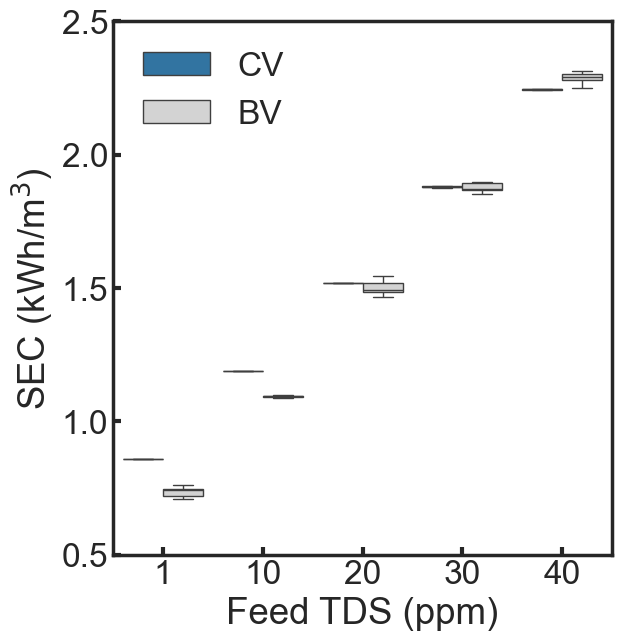

In [ ]:
# Description: Visualize the SEC distribution comparison between CV and BV configurations.
# 1) Tag the rows by trial type
cv = overall_df.copy()
cv["trial"] = "CV"

bv = overall_df_BV.copy()
bv["trial"] = "BV"

# 2) Merge and treat feed-TDS as categorical
df_plot = pd.concat([cv, bv], ignore_index=True)
df_plot["c_feed_input"] = df_plot["c_feed_input"].astype(str)
order = sorted(df_plot["c_feed_input"].unique())

# 3) Create boxplot
fig = plt.figure(figsize=(7, 7))
ax = sns.boxplot(
    data=df_plot,
    x="c_feed_input",
    y="sec_obj",
    hue="trial",
    order=order,
    showfliers=False,
    width=0.8,
    linewidth=1.0,
    palette={"CV": "#1f77b4", "BV": "lightgrey"}
)

plt.xlabel("Feed TDS (ppm)")
plt.ylabel("SEC (kWh/m$^{3}$)")
plt.ylim(0.5, 2.5)
plt.legend(title="", frameon=False)
plt.tight_layout()
plt.show()

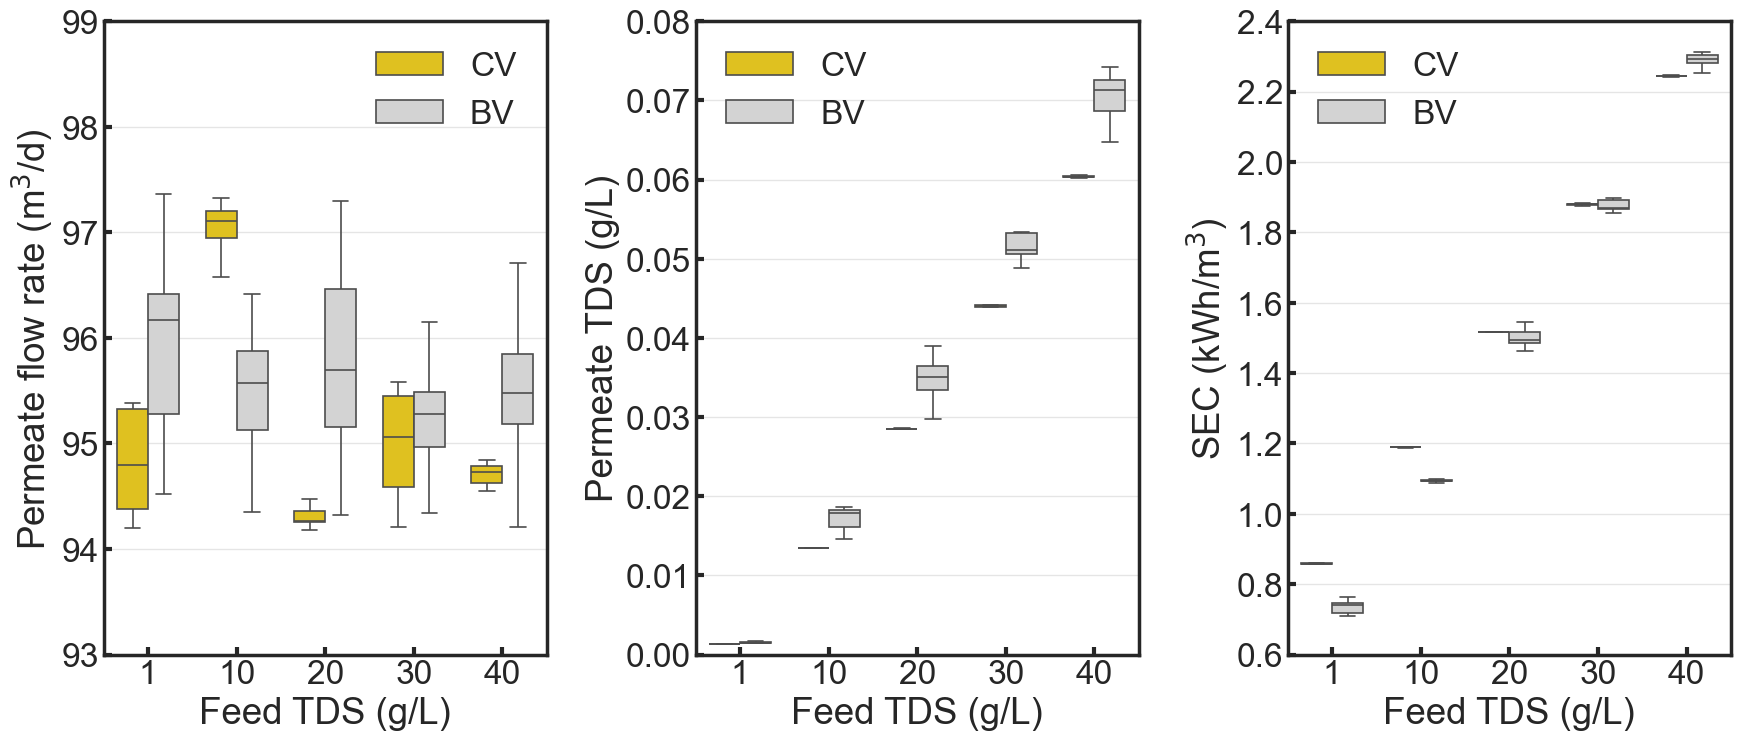

In [ ]:
# Description: Generate boxplots comparing Permeate Flow, TDS, and SEC for CV and BV.
# 1) Tag the rows by trial type
cv = overall_df.copy()
cv["trial"] = "CV"

bv = overall_df_BV.copy()
bv["trial"] = "BV"

# 2) Merge and treat feed-TDS as categorical
df_plot = pd.concat([cv, bv], ignore_index=True)
df_plot["c_feed_input"] = df_plot["c_feed_input"].astype(str)
order = sorted(df_plot["c_feed_input"].unique())

# 3) Create subplots for different y variables
y_vars = ["Qp_sum", "perm avg TDS", "sec_obj"]
y_labels = ["Permeate flow rate (m$^3$/d)", "Permeate TDS (g/L)", "SEC (kWh/m$^{3}$)"]
y_lims = [(93, 99), (0, 0.08), (0.6, 2.4)]

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharex=True)

for ax, y_var, y_label, y_lim in zip(axes, y_vars, y_labels, y_lims):
    sns.boxplot(
        data=df_plot,
        x="c_feed_input",
        y=y_var,
        hue="trial",
        order=order,
        showfliers=False,
        width=0.7,
        linewidth=1.2,
        palette={"CV": "gold", "BV": "lightgrey"},
        ax=ax
    )
    ax.set_xlabel("Feed TDS (g/L)")
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    ax.legend(title="", frameon=False)
    ax.grid(axis='y', alpha=0.5)  # Add horizontal gridlines with high transparency

plt.tight_layout()
plt.show()

In [ ]:
# Description: Calculate and display median and minimum values for key metrics.
# Extract medians for each variable
median_df = (
    df_plot.groupby(["c_feed_input", "trial"])[y_vars]
    .median()
    .reset_index()
    .sort_values(by=["c_feed_input", "trial"])
)
print(median_df)

# Extract minimum values for each variable
min_df = (
    df_plot.groupby(["c_feed_input", "trial"])[y_vars]
    .min()
    .reset_index()
    .sort_values(by=["c_feed_input", "trial"])
)
print(min_df)

  c_feed_input trial     Qp_sum  perm avg TDS   sec_obj
0            1    BV  96.170713      0.001525  0.740846
1            1    CV  94.792166      0.001335  0.858071
2           10    BV  95.574366      0.017882  1.094183
3           10    CV  97.105995      0.013450  1.189196
4           20    BV  95.699982      0.035030  1.493804
5           20    CV  94.268391      0.028550  1.516670
6           30    BV  95.277892      0.051073  1.870422
7           30    CV  95.062921      0.044011  1.879291
8           40    BV  95.474634      0.071370  2.292149
9           40    CV  94.731582      0.060326  2.244616
  c_feed_input trial     Qp_sum  perm avg TDS   sec_obj
0            1    BV  94.519990      0.001427  0.709630
1            1    CV  94.202407      0.001330  0.857451
2           10    BV  94.346462      0.014626  1.080594
3           10    CV  96.548244      0.013434  1.186794
4           20    BV  94.318785      0.029744  1.464090
5           20    CV  94.175593      0.028531  1

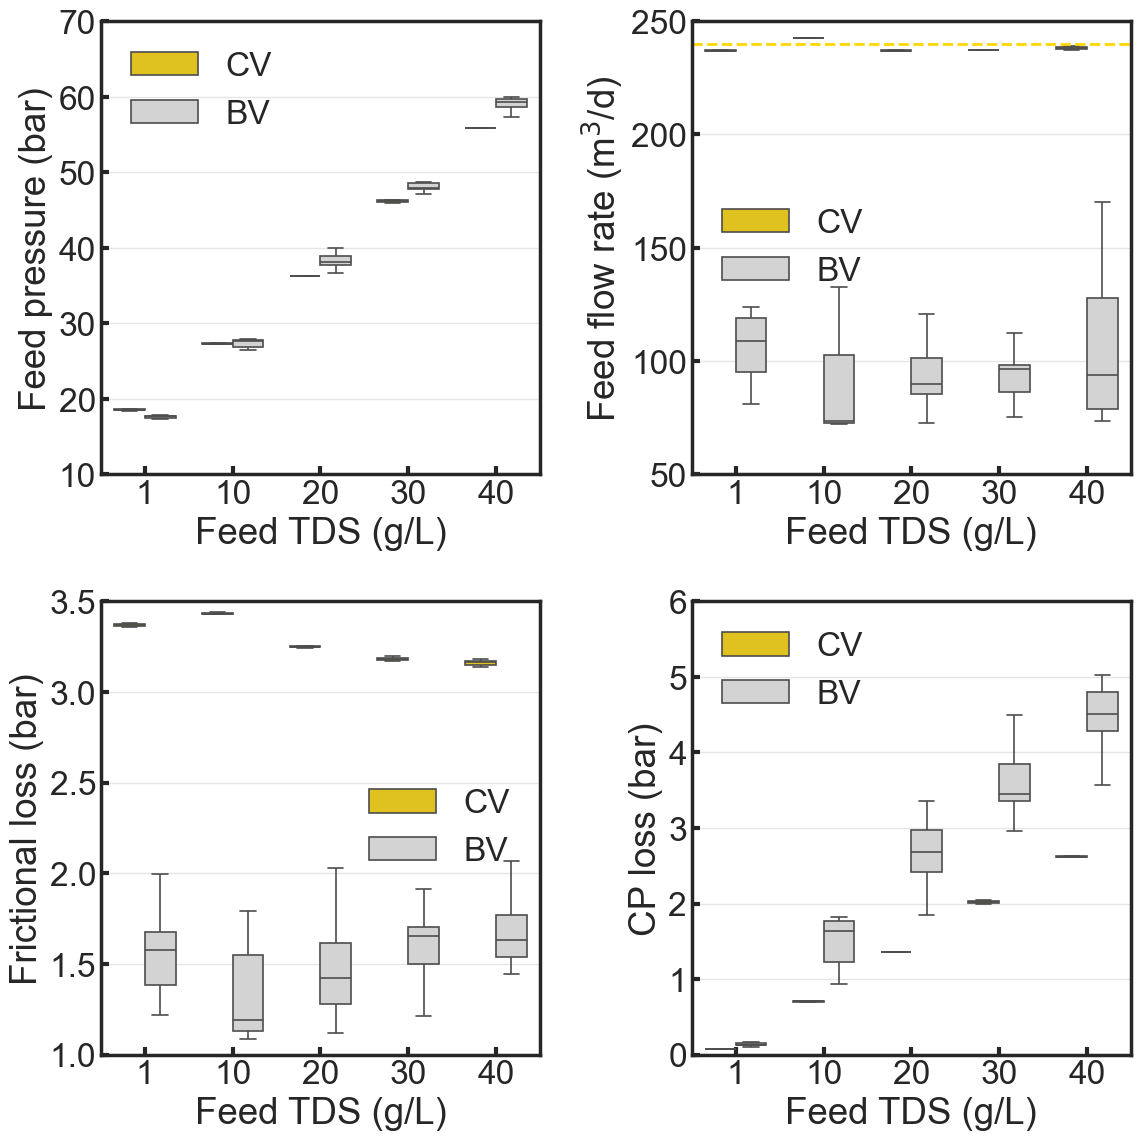

In [ ]:
# Description: Generate boxplots for operational parameters (Pressure, Feed Flow, Friction Loss, CP Loss).
# 1) Tag the rows by trial type
cv = overall_df.copy()
cv["trial"] = "CV"

bv = overall_df_BV.copy()
bv["trial"] = "BV"

# 2) Merge and treat feed-TDS as categorical
df_plot = pd.concat([cv, bv], ignore_index=True)
df_plot["c_feed_input"] = df_plot["c_feed_input"].astype(str)

# Convert pressure values from Pa to bar
df_plot["fric loss"] = df_plot["fric loss"] / 1e5
df_plot["osmo_excess"] = df_plot["osmo_excess"] / 1e5

order = sorted(df_plot["c_feed_input"].unique())

# 3) Create subplots for different y variables
y_vars = ["input_pressure_var", "initial_feed_flow_var", "fric loss", "osmo_excess"]
y_labels = ["Feed pressure (bar)", r"Feed flow rate (m$^3$/d)", "Frictional loss (bar)", "CP loss (bar)"]
y_lims = [(10, 70), (50, 250), (1, 3.5), (0, 6)]

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=False)
axes = axes.flatten()  # Flatten the 2D array of axes into 1D

for ax, y_var, y_label, y_lim in zip(axes, y_vars, y_labels, y_lims):
    sns.boxplot(
        data=df_plot,
        x="c_feed_input",
        y=y_var,
        hue="trial",
        order=order,
        showfliers=False,
        width=0.7,
        linewidth=1.2,
        palette={"CV": "gold", "BV": "lightgrey"},
        ax=ax
    )
    ax.set_xlabel("Feed TDS (g/L)")
    ax.set_ylabel(y_label)
    ax.set_ylim(y_lim)
    ax.legend(title="", frameon=False)
    ax.grid(axis='y', alpha=0.5)

    # Add horizontal line at 240 m3/d for feed flow rate plot
    if y_var == "initial_feed_flow_var":
        ax.axhline(240, color='gold', linestyle='--', linewidth=2, label="Design flow rate")

plt.tight_layout()
plt.show()

In [ ]:
# Description: Perform feature importance analysis using SHAP for individual feed concentrations.
bypass_cols = [f'bypass_{i+1}' for i in range(6)]
bypass_df = overall_df_BV['decision_variables'].apply(lambda x: x[:6]).apply(pd.Series)
bypass_df.columns = bypass_cols
df_final = pd.concat([overall_df_BV, bypass_df], axis=1)
# --- 2. Iterate Through Each Feed Concentration Case ---
unique_feeds = df_final['c_feed_input'].unique()

for feed_value in unique_feeds:
    print(f"\n{'='*20} ANALYSIS FOR C_FEED_INPUT = {feed_value} {'='*20}")

    df_case = df_final[df_final['c_feed_input'] == feed_value].copy()
    y_case = df_case['sec_obj']
    features_to_drop = ['sec_obj', 'decision_variables', 'c_feed_input']
    X_case = df_case.drop(columns=features_to_drop)

    model_case = RandomForestRegressor(n_estimators=50, random_state=42)
    model_case.fit(X_case, y_case)

    explainer = shap.Explainer(model_case)
    shap_values = explainer(X_case)

    mean_shap = pd.DataFrame(shap_values.values, columns=X_case.columns).mean()
    total_impact_magnitude = mean_shap.abs().sum()

    # Select all 'bypass_' features, then drop 'bypass_ratio'
    bypass_shap_all = mean_shap[mean_shap.index.str.startswith('bypass_')]
    bypass_shap = bypass_shap_all.drop('bypass_ratio', errors='ignore')

    impact_ratios = (bypass_shap / total_impact_magnitude) * 100

    print("Bypass Flow Contribution to Total Feature Impact:")
    print(impact_ratios.sort_values(ascending=False).to_string(float_format='{:.2f}%'.format))

    # --- 3. Generate and Save Bar Plot (MODIFIED) ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))

    # **MODIFICATION 1: Sort by index (bypass_1, bypass_2, etc.) for fixed order**
    impact_ratios_ordered = impact_ratios.sort_index()

    # **MODIFICATION 2: Plot the ordered data**
    ax.bar(impact_ratios_ordered.index, impact_ratios_ordered.values, color='skyblue')
    ax.set_ylabel('Contribution to Total Impact (%)', fontsize=12)
    ax.set_title(f'Bypass Flow Impact Contribution for c_feed_input = {feed_value}', fontsize=14)
    ax.tick_params(axis='x', rotation=0) # Keep x-axis labels horizontal

    # Add percentage labels on top of bars
    for i, v in enumerate(impact_ratios_ordered.values):
        ax.text(i, v + 0.05, f"{v:.2f}%", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()

    plot_filename = f'impact_ratios_case_{feed_value}.png'
    plt.savefig(plot_filename)
    plt.close(fig)

    print(f"Saved plot to {plot_filename}")

print(f"\n{'='*60}")


==================== ANALYSIS FOR C_FEED_INPUT = 1 ====================
Bypass Flow Contribution to Total Feature Impact:
bypass_3    0.33%
bypass_5    0.06%
bypass_2   -0.22%
bypass_4   -0.97%
bypass_1   -1.72%
bypass_6   -2.75%
Saved plot to impact_ratios_case_1.png

==================== ANALYSIS FOR C_FEED_INPUT = 10 ====================
Bypass Flow Contribution to Total Feature Impact:
bypass_2     6.26%
bypass_4     5.22%
bypass_1    -1.48%
bypass_5    -2.69%
bypass_3    -6.01%
bypass_6   -11.33%
Saved plot to impact_ratios_case_10.png

==================== ANALYSIS FOR C_FEED_INPUT = 20 ====================
Bypass Flow Contribution to Total Feature Impact:
bypass_5   15.79%
bypass_4    0.51%
bypass_6    0.12%
bypass_2   -0.76%
bypass_1   -1.05%
bypass_3   -1.60%
Saved plot to impact_ratios_case_20.png

==================== ANALYSIS FOR C_FEED_INPUT = 30 ====================
Bypass Flow Contribution to Total Feature Impact:
bypass_6     8.44%
bypass_3     1.94%
bypass_1     0.01%


--- Analyzing case for c_feed_input = 1 ---

--- Analyzing case for c_feed_input = 10 ---

--- Analyzing case for c_feed_input = 20 ---

--- Analyzing case for c_feed_input = 30 ---

--- Analyzing case for c_feed_input = 40 ---


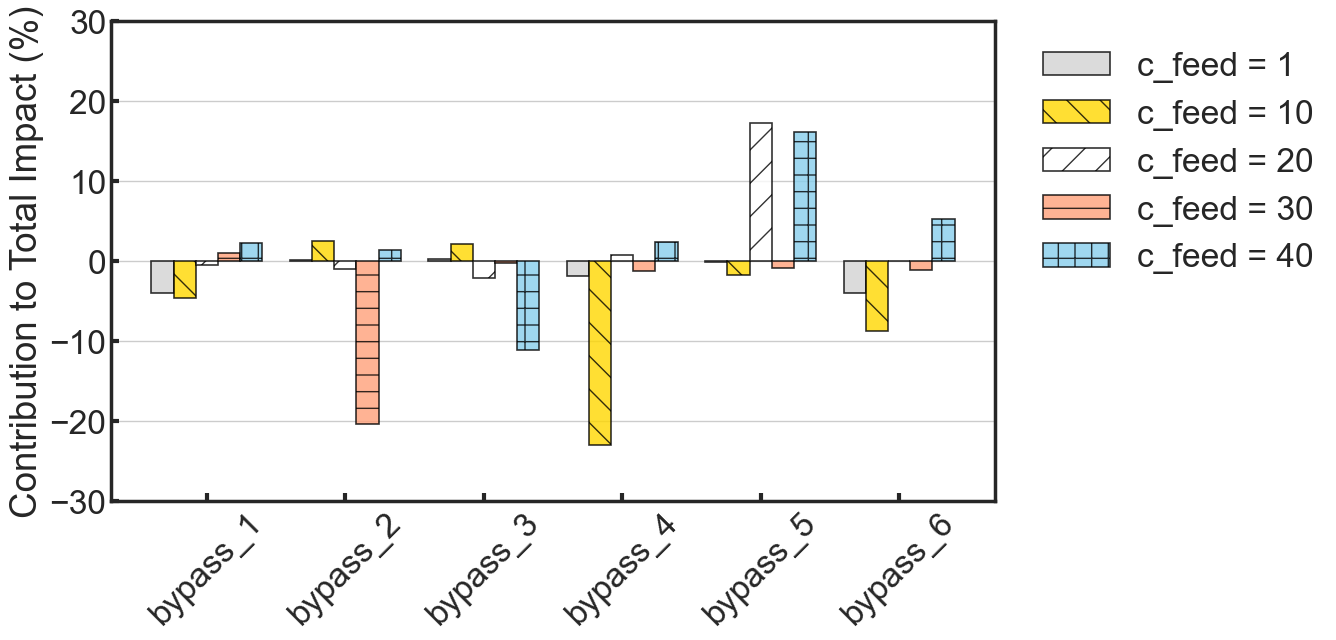

In [ ]:
# Description: Aggregate SHAP values and generate a combined bar plot for feature importance.
bypass_cols = [f'bypass_{i+1}' for i in range(6)]
bypass_df = overall_df_BV['decision_variables'].apply(lambda x: x[:6]).apply(pd.Series)
bypass_df.columns = bypass_cols
df_final = pd.concat([overall_df_BV, bypass_df], axis=1)

# --- 2. Iterate and Collect Results ---
unique_feeds = sorted(df_final['c_feed_input'].unique())
all_ratios = {} # Dictionary to store results from each case

for feed_value in unique_feeds:
    print(f"\n--- Analyzing case for c_feed_input = {feed_value} ---")
    df_case = df_final[df_final['c_feed_input'] == feed_value].copy()
    y_case = df_case['sec_obj']
    features_to_drop = ['sec_obj', 'decision_variables', 'c_feed_input']
    X_case = df_case.drop(columns=features_to_drop)

    model_case = RandomForestRegressor(n_estimators=200, random_state=42)
    model_case.fit(X_case, y_case)

    explainer = shap.Explainer(model_case)
    shap_values = explainer(X_case)
    mean_shap = pd.DataFrame(shap_values.values, columns=X_case.columns).mean()
    total_impact_magnitude = mean_shap.abs().sum()

    bypass_shap_all = mean_shap[mean_shap.index.str.startswith('bypass_')]
    bypass_shap = bypass_shap_all.drop('bypass_ratio', errors='ignore')

    impact_ratios = (bypass_shap / total_impact_magnitude) * 100
    all_ratios[feed_value] = impact_ratios.sort_index()

# --- 3. Prepare Data and Generate Combined Plot ---
ratios_df = pd.DataFrame(all_ratios)

fig, ax = plt.subplots(figsize=(14, 7))

# MODIFICATION: Define colors and hatches
hatches = ['', '\\', '/', '-', '+']
colors = ['lightgrey', 'gold', 'white', 'lightsalmon', 'skyblue']
n_cases = len(ratios_df.columns)
bar_width = 0.8 / n_cases
x = np.arange(len(ratios_df.index))

# Create a bar for each case with color, transparency, and hatch
for i, case in enumerate(ratios_df.columns):
    offset = (i - (n_cases - 1) / 2) * bar_width
    bars = ax.bar(x + offset, ratios_df[case], width=bar_width,
                  label=f'c_feed = {case}',
                  hatch=hatches[i % len(hatches)],
                  edgecolor='black',
                  linewidth=1.2,
                  color=colors[i % len(colors)],
                  alpha=0.8)

# Formatting the plot
ax.set_ylabel('Contribution to Total Impact (%)')
ax.set_xticks(x)
ax.set_xticklabels(ratios_df.index, rotation=45)
ax.set_ylim(-30, 30)
ax.grid(axis='y')

# MODIFICATION: Move legend outside the plot area
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.show()

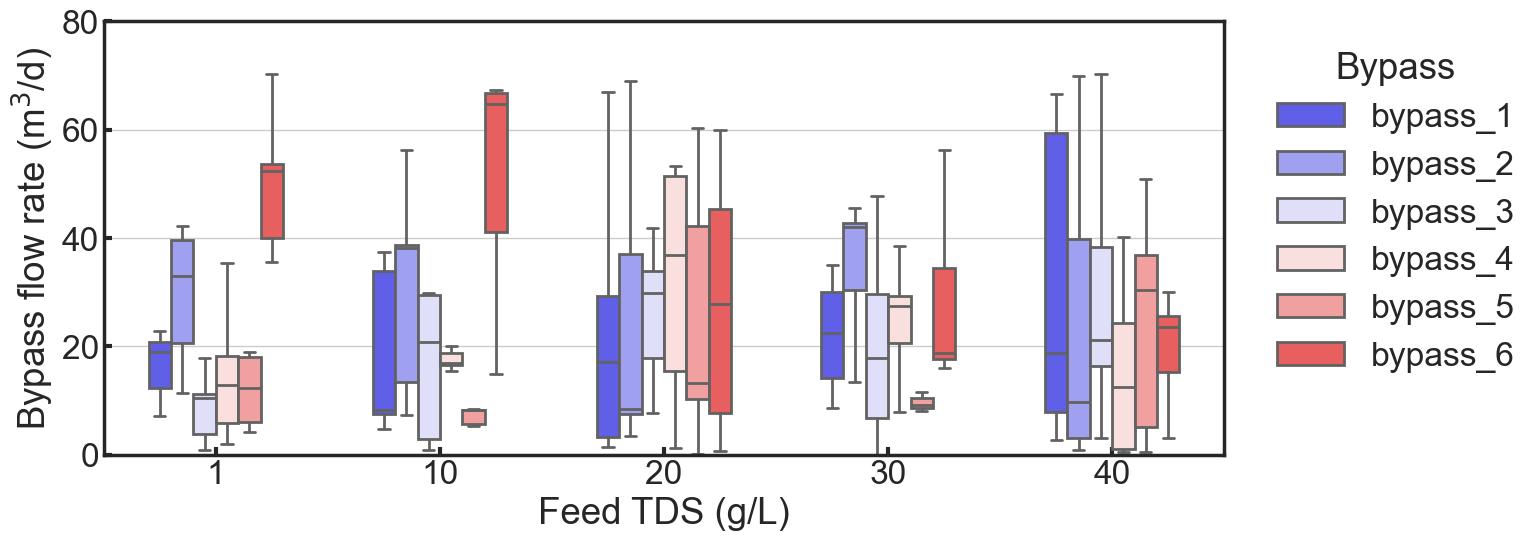

In [ ]:
# Description: Visualize the distribution of bypass flow rates across different feed concentrations.
bypass_cols = [f'bypass_{i+1}' for i in range(6)]
bypass_df = overall_df_BV['decision_variables'].apply(lambda x: x[:6]).apply(pd.Series)
bypass_df.columns = bypass_cols
df_final = pd.concat([overall_df_BV, bypass_df], axis=1)

# Melt for grouped boxplot
df_long = df_final.melt(
    id_vars='c_feed_input',
    value_vars=bypass_cols,
    var_name='bypass_type',
    value_name='bypass_value'
)

# Convert to daily units
df_long['bypass_value'] *= 3600 * 24

fig = plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=df_long,
    x='c_feed_input',
    y='bypass_value',
    hue='bypass_type',
    palette='bwr',
    showfliers=False,
    linewidth=2,
    width=0.6
)

ax.set_ylabel(r'Bypass flow rate (m$^3$/d)')
ax.set_xlabel('Feed TDS (g/L)')
ax.set_ylim(0, 80)
ax.grid(axis='y')

# Move legend outside
ax.legend(title='Bypass', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

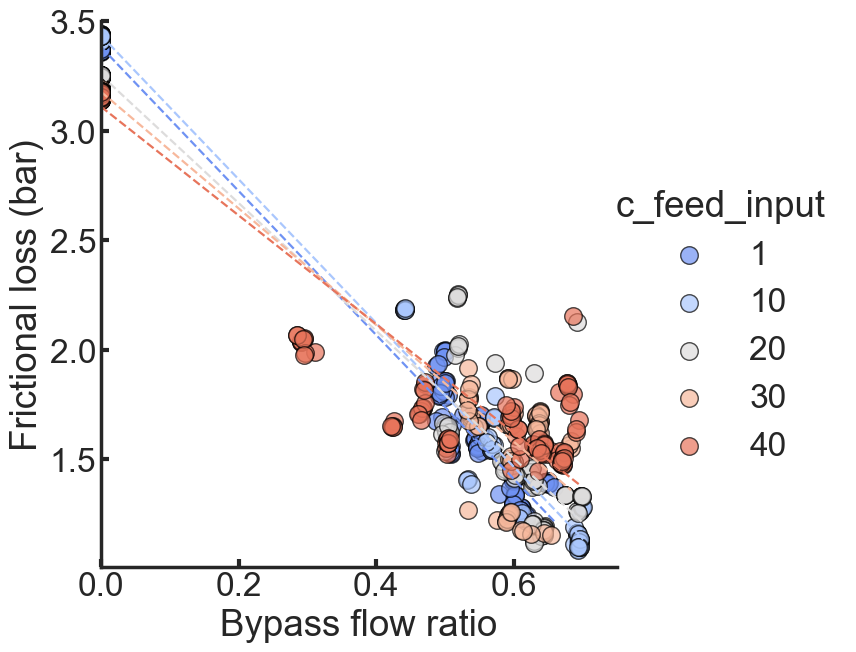

In [ ]:
# Description: Create a scatter plot with regression lines showing Friction Loss vs. Bypass Ratio.
overall_df['fric_loss_scaled'] = overall_df['fric loss'] / 100000
overall_df_BV['fric_loss_scaled'] = overall_df_BV['fric loss'] / 100000
df_final = pd.concat([overall_df, overall_df_BV])

# --- Plotting Code ---
# Use lmplot to create the scatter plot and regression lines in one step
fig = sns.lmplot(
    data=df_final,
    x='bypass_ratio',
    y='fric_loss_scaled',
    hue='c_feed_input',
    palette='coolwarm',
    height=7,  # Controls figure size
    ci=None,
    # Pass scatter plot styling arguments here
    scatter_kws={
        's': 160,
        'edgecolor': 'black',
        'alpha': 0.7
    },
    line_kws={
        'lw': 1.6,           # Thinner line width
        'alpha': 1.0,      # Semi-transparent
        'ls': '--'         # Dashed line style
    }
)

# Set axis labels
plt.xlabel('Bypass flow ratio')
plt.xlim(0, 0.75)
plt.ylim(1.01, 3.5)
plt.ylabel('Frictional loss (bar)')
plt.show()

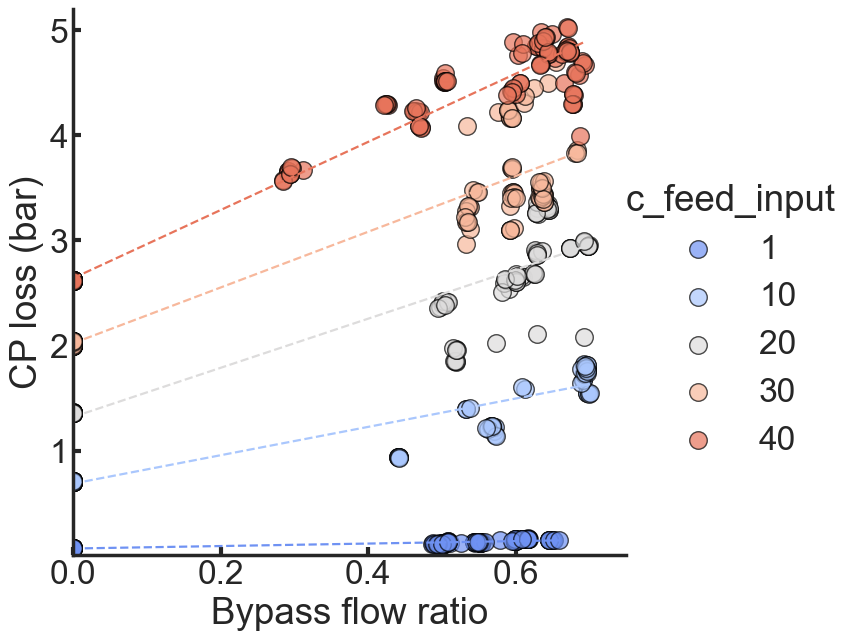

In [ ]:
# Description: Create a scatter plot with regression lines showing CP Loss vs. Bypass Ratio.
overall_df['osmo_excess_scaled'] = overall_df['osmo_excess'] / 100000
overall_df_BV['osmo_excess_scaled'] = overall_df_BV['osmo_excess'] / 100000
df_final = pd.concat([overall_df, overall_df_BV])

# --- Plotting Code ---
# Use lmplot to create the scatter plot and regression lines in one step
fig = sns.lmplot(
    data=df_final,
    x='bypass_ratio',
    y='osmo_excess_scaled',
    hue='c_feed_input',
    palette='coolwarm',
    height=7,  # Controls figure size
    ci=None,
    # Pass scatter plot styling arguments here
    scatter_kws={
        's': 160,
        'edgecolor': 'black',
        'alpha': 0.7
    },
    line_kws={
        'lw': 1.6,           # Thinner line width
        'alpha': 1.0,      # Semi-transparent
        'ls': '--'         # Dashed line style
    }
)

# Set axis labels
plt.xlabel('Bypass flow ratio')
plt.xlim(0, 0.75)
plt.ylim(0.01, 5.2)
plt.ylabel('CP loss (bar)')
plt.show()